In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# преобразование данных: нормализация и аугментация
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # преобразование в одноканальный формат
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # нормализация для одноканальных изображений
])

# загрузка датасета CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/30, Train Loss: 1.8219, Train Acc: 33.66%, Test Loss: 1.5511, Test Acc: 43.92%
Epoch 2/30, Train Loss: 1.5164, Train Acc: 45.35%, Test Loss: 1.3484, Test Acc: 52.31%
Epoch 3/30, Train Loss: 1.3620, Train Acc: 51.17%, Test Loss: 1.2576, Test Acc: 55.50%
Epoch 4/30, Train Loss: 1.2729, Train Acc: 54.98%, Test Loss: 1.1846, Test Acc: 58.70%
Epoch 5/30, Train Loss: 1.2137, Train Acc: 57.11%, Test Loss: 1.1053, Test Acc: 62.12%
Epoch 6/30, Train Loss: 1.1581, Train Acc: 59.48%, Test Loss: 1.0810, Test Acc: 62.39%
Epoch 7/30, Train Loss: 1.1354, Train Acc: 59.96%, Test Loss: 1.0488, Test Acc: 63.23%
Epoch 8/30, Train Loss: 1.0980, Train Acc: 61.64%, Test Loss: 1.0184, Test Acc: 65.31%
Epoch 9/30, Train Loss: 1.0749, Train Acc: 62.18%, Test Loss: 0.9970, Test Acc: 65.70%
Epoch 10/30, Train Loss: 1.0523, Train Acc: 63.46%, Test Loss: 0.9974, Test Acc: 65.19%
Epoch 11/30, Train Loss: 1.0283, Train Acc: 64.23%, Test Loss: 0.9899, Test Acc: 65.98%
Epoch 12/30, Train Loss: 1.0181, Train Ac

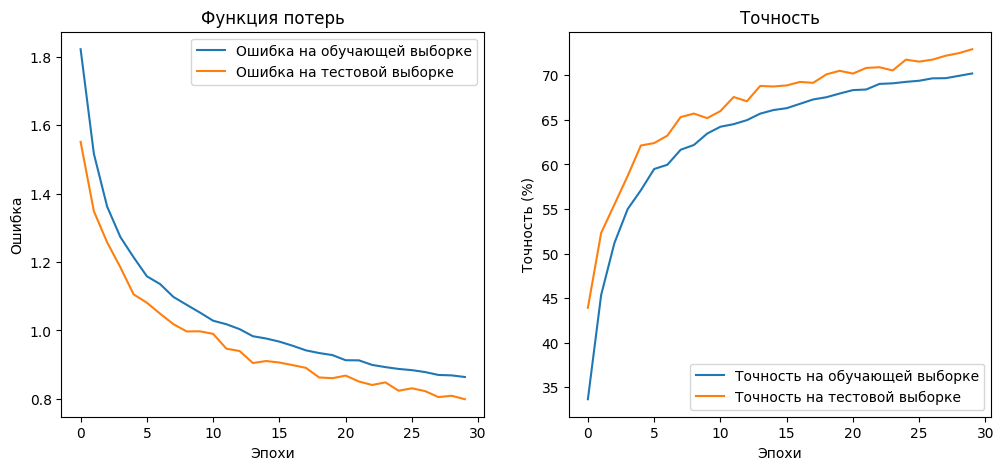

In [9]:
# определение архитектуры сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 1 канал на входе
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 8x8 для изображений 32x32 после двух пулингов
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# функция для обучения модели
def train_model(model, optimizer, criterion, trainloader, testloader, epochs=10):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # обучение на обучающей выборке
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # сохранение ошибки и точности для обучающей выборки
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # оценка на тестовой выборке
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # сохранение ошибки и точности для тестовой выборки
        test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        # вывод статистики
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history

# инициализация модели, функции потерь и оптимизатора
basic_net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(basic_net.parameters(), lr=0.001)

# обучение модели
train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(
    basic_net, optimizer, criterion, trainloader, testloader, epochs=30
)

# визуализация функции потерь и точности
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Ошибка на обучающей выборке')
plt.plot(test_loss_history, label='Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Функция потерь')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Точность на обучающей выборке')
plt.plot(test_acc_history, label='Точность на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.title('Точность')
plt.legend()

plt.show()

Как мы видим ошибка на test ниже, чем на train. Это может быть связано с тем, что

* тестовая выборка проще
* модель хорошо обобщает

Также это не сявзано с переобучением, т.к. ошибка на тесте остается стабильной при увеличении количества эпох


А граница в accuracy ~ 70%, потому что архитектура сети проста и для увеличения точности можно увеличить кол-во слоев или их комбинацию. 

Files already downloaded and verified
Files already downloaded and verified
Обучение на датасете: CIFAR-10
Epoch 1/30, Train Loss: 1.7639, Train Acc: 36.03%, Test Loss: 1.4706, Test Acc: 48.01%
Epoch 2/30, Train Loss: 1.4290, Train Acc: 48.98%, Test Loss: 1.3128, Test Acc: 53.45%
Epoch 3/30, Train Loss: 1.2981, Train Acc: 54.17%, Test Loss: 1.2365, Test Acc: 56.82%
Epoch 4/30, Train Loss: 1.2272, Train Acc: 56.75%, Test Loss: 1.1243, Test Acc: 60.81%
Epoch 5/30, Train Loss: 1.1688, Train Acc: 58.70%, Test Loss: 1.0671, Test Acc: 62.95%
Epoch 6/30, Train Loss: 1.1276, Train Acc: 60.36%, Test Loss: 1.0346, Test Acc: 64.26%
Epoch 7/30, Train Loss: 1.0871, Train Acc: 62.10%, Test Loss: 0.9898, Test Acc: 65.45%
Epoch 8/30, Train Loss: 1.0612, Train Acc: 62.88%, Test Loss: 1.0039, Test Acc: 65.23%
Epoch 9/30, Train Loss: 1.0345, Train Acc: 63.92%, Test Loss: 0.9784, Test Acc: 66.44%
Epoch 10/30, Train Loss: 1.0104, Train Acc: 64.61%, Test Loss: 0.9367, Test Acc: 67.52%
Epoch 11/30, Train Los

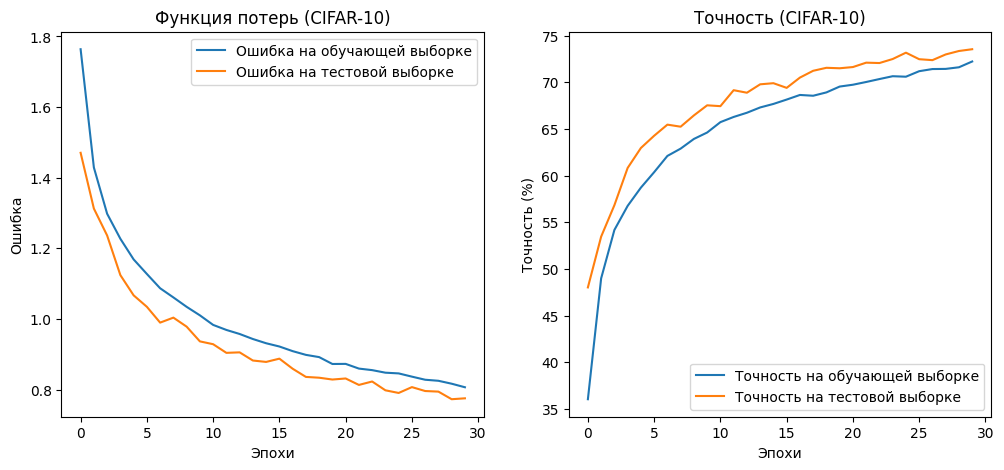

In [10]:
# функция для обучения модели на конкретном датасете
def train_on_dataset(model, optimizer, criterion, trainloader, testloader, dataset_name, epochs=10):
    print(f"Обучение на датасете: {dataset_name}")
    train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(
        model, optimizer, criterion, trainloader, testloader, epochs
    )
    
    # визуализация функции потерь и точности
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Ошибка на обучающей выборке')
    plt.plot(test_loss_history, label='Ошибка на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.title(f'Функция потерь ({dataset_name})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Точность на обучающей выборке')
    plt.plot(test_acc_history, label='Точность на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность (%)')
    plt.title(f'Точность ({dataset_name})')
    plt.legend()
    
    plt.show()

# аугментация для CIFAR-10
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # преобразование в одноканальный формат
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # нормализация для одноканальных изображений
])

"""
предобработка такая потому что:
RandomHorizontalFlip - помогает модели лучше обобщать, так как многие объекты в CIFAR-10 симметричны
RandomCrop - добавляет разнообразие в данные, обрезая изображения случайным образом.
"""


# загрузка CIFAR-10
trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=128, shuffle=True, num_workers=2)

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=128, shuffle=False, num_workers=2)

# обучение на CIFAR-10
model_cifar = Net()
optimizer_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)
criterion_cifar = nn.CrossEntropyLoss()
train_on_dataset(model_cifar, optimizer_cifar, criterion_cifar, trainloader_cifar, testloader_cifar, "CIFAR-10", epochs=30)

100.0%


100.0%


Обучение на датасете: SVHN
Epoch 1/30, Train Loss: 1.8468, Train Acc: 35.03%, Test Loss: 1.4699, Test Acc: 49.51%
Epoch 2/30, Train Loss: 1.3365, Train Acc: 54.34%, Test Loss: 1.1651, Test Acc: 62.24%
Epoch 3/30, Train Loss: 1.1245, Train Acc: 62.50%, Test Loss: 0.9930, Test Acc: 68.40%
Epoch 4/30, Train Loss: 1.0099, Train Acc: 66.89%, Test Loss: 0.8921, Test Acc: 72.40%
Epoch 5/30, Train Loss: 0.9370, Train Acc: 69.42%, Test Loss: 0.8372, Test Acc: 73.91%
Epoch 6/30, Train Loss: 0.8996, Train Acc: 70.77%, Test Loss: 0.7713, Test Acc: 75.87%
Epoch 7/30, Train Loss: 0.8647, Train Acc: 72.16%, Test Loss: 0.7382, Test Acc: 77.06%
Epoch 8/30, Train Loss: 0.8340, Train Acc: 73.35%, Test Loss: 0.7146, Test Acc: 77.82%
Epoch 9/30, Train Loss: 0.8134, Train Acc: 74.02%, Test Loss: 0.7007, Test Acc: 78.30%
Epoch 10/30, Train Loss: 0.7998, Train Acc: 74.42%, Test Loss: 0.6774, Test Acc: 79.31%
Epoch 11/30, Train Loss: 0.7789, Train Acc: 75.26%, Test Loss: 0.6965, Test Acc: 78.55%
Epoch 12/30, T

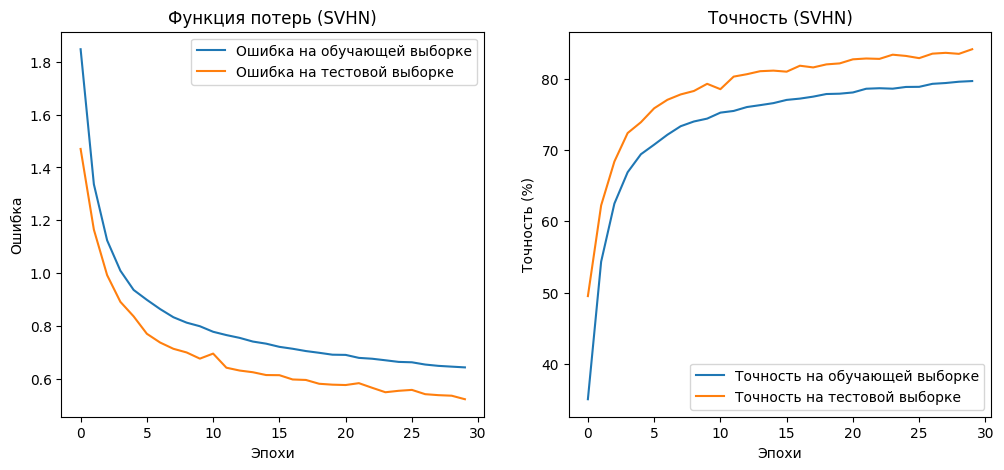

In [17]:
# аугментация для SVHN
transform_svhn = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # преобразование в одноканальный формат
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # нормализация для одноканальных изображений
])
"""
предобработка такая потому что:
RandomHorizontalFlip - менее полезен для цифр, но может помочь в некоторых случаях.
RandomCrop - добавляет разнообразие, обрезая изображения случайным образом.
ColorJitter - имитирует изменения освещения и контраста, что полезно для реальных данных.
"""


# загрузка SVHN
trainset_svhn = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_svhn)
trainloader_svhn = torch.utils.data.DataLoader(trainset_svhn, batch_size=128, shuffle=True, num_workers=2)

testset_svhn = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)
testloader_svhn = torch.utils.data.DataLoader(testset_svhn, batch_size=128, shuffle=False, num_workers=2)

# обучение на SVHN
model_svhn = Net()
optimizer_svhn = optim.Adam(model_svhn.parameters(), lr=0.001)
criterion_svhn = nn.CrossEntropyLoss()
train_on_dataset(model_svhn, optimizer_svhn, criterion_svhn, trainloader_svhn, testloader_svhn, "SVHN", epochs=30)

Обучение на датасете: Fashion-MNIST
Epoch 1/30, Train Loss: 0.4998, Train Acc: 81.85%, Test Loss: 0.4009, Test Acc: 85.14%
Epoch 2/30, Train Loss: 0.3307, Train Acc: 87.74%, Test Loss: 0.3344, Test Acc: 87.39%
Epoch 3/30, Train Loss: 0.2799, Train Acc: 89.73%, Test Loss: 0.2908, Test Acc: 89.36%
Epoch 4/30, Train Loss: 0.2519, Train Acc: 90.72%, Test Loss: 0.2759, Test Acc: 89.81%
Epoch 5/30, Train Loss: 0.2337, Train Acc: 91.30%, Test Loss: 0.2603, Test Acc: 90.56%
Epoch 6/30, Train Loss: 0.2169, Train Acc: 91.91%, Test Loss: 0.2633, Test Acc: 90.88%
Epoch 7/30, Train Loss: 0.2007, Train Acc: 92.49%, Test Loss: 0.2567, Test Acc: 91.02%
Epoch 8/30, Train Loss: 0.1924, Train Acc: 92.94%, Test Loss: 0.2575, Test Acc: 90.92%
Epoch 9/30, Train Loss: 0.1809, Train Acc: 93.32%, Test Loss: 0.2452, Test Acc: 91.35%
Epoch 10/30, Train Loss: 0.1715, Train Acc: 93.58%, Test Loss: 0.2482, Test Acc: 91.69%
Epoch 11/30, Train Loss: 0.1631, Train Acc: 93.91%, Test Loss: 0.2461, Test Acc: 91.52%
Epoch

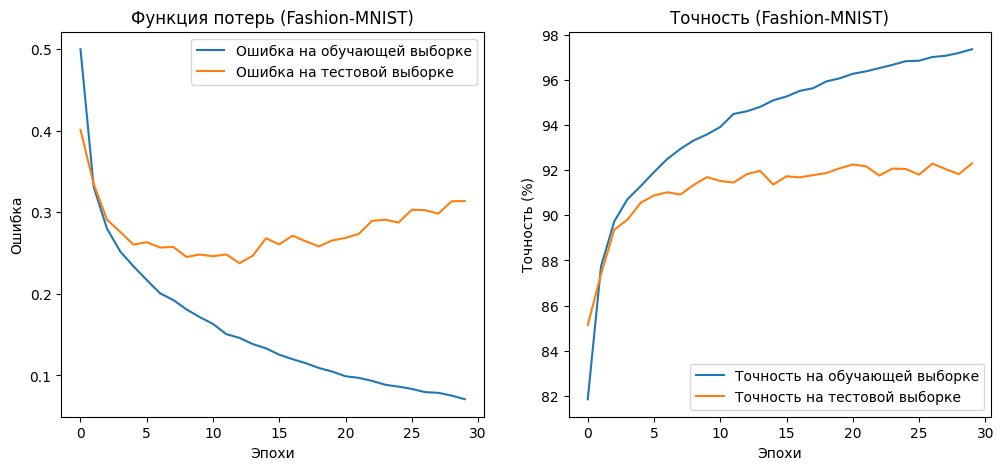

In [20]:
# У MNIST размер изображения 28x28 и надо переписать сеть
class FasionNet(nn.Module):
    def __init__(self):
        super(FasionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 1 канал на входе
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # 7x7 для изображений 28x28 после двух пулингов
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(nn.functional.relu(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(-1, 64 * 7 * 7)  # преобразование в вектор
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# аугментация для Fashion-MNIST
transform_fashion_mnist = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # случайное отражение по горизонтали
    transforms.RandomRotation(10),      # случайный поворот на 10 градусов
    transforms.ToTensor(),              # преобразование в тензор
    transforms.Normalize((0.5,), (0.5,))  # нормализация для одноканальных изображений
])

"""
Предобработка такая, потому что:
- RandomHorizontalFlip: полезен для одежды, так как многие предметы симметричны (например, футболки, ботинки).
- RandomRotation: добавляет разнообразие, имитируя небольшие повороты объектов.
- ToTensor: преобразует изображения в тензоры PyTorch.
- Normalize: нормализует значения пикселей в диапазон [-1, 1] для улучшения сходимости модели.
"""

# загрузка Fashion-MNIST
trainset_fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion_mnist)
trainloader_fashion_mnist = torch.utils.data.DataLoader(trainset_fashion_mnist, batch_size=100, shuffle=True, num_workers=2, drop_last=True)

testset_fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion_mnist)
testloader_fashion_mnist = torch.utils.data.DataLoader(testset_fashion_mnist, batch_size=100, shuffle=False, num_workers=2, drop_last=True)

# обучение на Fashion-MNIST
model_fashion_mnist = FasionNet()  # создание модели
optimizer_fashion_mnist = optim.Adam(model_fashion_mnist.parameters(), lr=0.001)  # оптимизатор Adam
criterion_fashion_mnist = nn.CrossEntropyLoss()  # функция потерь

# запуск обучения
train_on_dataset(model_fashion_mnist, optimizer_fashion_mnist, criterion_fashion_mnist, trainloader_fashion_mnist, testloader_fashion_mnist, "Fashion-MNIST", epochs=30)

Тут видно, что модель, начиная с 4 эпохи, переобучается. Поэтому упростим модель и добавим возможность ранней остановки.

Epoch 1/30, Train Loss: 0.5766, Train Acc: 79.27%, Test Loss: 0.4728, Test Acc: 82.38%
Epoch 2/30, Train Loss: 0.3732, Train Acc: 86.34%, Test Loss: 0.3629, Test Acc: 87.21%
Epoch 3/30, Train Loss: 0.3265, Train Acc: 88.09%, Test Loss: 0.3399, Test Acc: 87.69%
Epoch 4/30, Train Loss: 0.2946, Train Acc: 89.07%, Test Loss: 0.3337, Test Acc: 87.95%
Epoch 5/30, Train Loss: 0.2718, Train Acc: 90.05%, Test Loss: 0.2920, Test Acc: 89.48%
Epoch 6/30, Train Loss: 0.2553, Train Acc: 90.52%, Test Loss: 0.2828, Test Acc: 89.61%
Epoch 7/30, Train Loss: 0.2389, Train Acc: 91.10%, Test Loss: 0.2714, Test Acc: 90.10%
Epoch 8/30, Train Loss: 0.2280, Train Acc: 91.60%, Test Loss: 0.2726, Test Acc: 90.38%
Epoch 9/30, Train Loss: 0.2185, Train Acc: 91.92%, Test Loss: 0.2638, Test Acc: 90.32%
Epoch 10/30, Train Loss: 0.2084, Train Acc: 92.32%, Test Loss: 0.2662, Test Acc: 90.37%
Epoch 11/30, Train Loss: 0.2017, Train Acc: 92.57%, Test Loss: 0.2735, Test Acc: 90.38%
Epoch 12/30, Train Loss: 0.1943, Train Ac

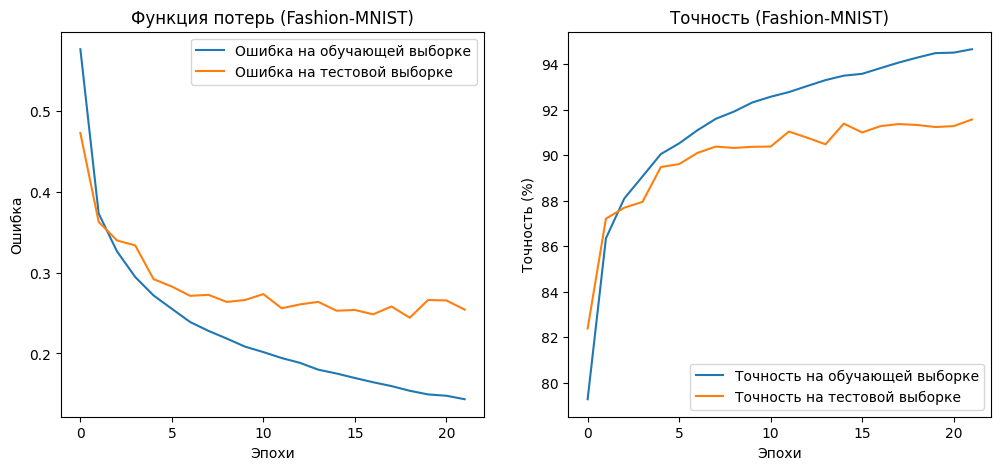

In [22]:
class FashionNetSimple(nn.Module):
    def __init__(self):
        super(FashionNetSimple, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # меньше фильтров (16 вместо 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # меньше фильтров (32 вместо 64)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)  # меньше нейронов (256 вместо 512)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  
        x = self.pool(nn.functional.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 7 * 7)  
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        """
        :param patience: Количество эпох без улучшения, после которых обучение останавливается.
        :param min_delta: Минимальное изменение тестового лосса для учета улучшения.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def __call__(self, test_loss):
        if test_loss < self.best_loss - self.min_delta:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

def train_model_with_early_stopping(model, optimizer, criterion, trainloader, testloader, dataset_name, epochs=10, patience=3):
    early_stopping = EarlyStopping(patience=patience)
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Обучение на обучающей выборке
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Сохранение ошибки и точности для обучающей выборки
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Оценка на тестовой выборке
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Сохранение ошибки и точности для тестовой выборки
        test_loss = test_loss / len(testloader)
        test_acc = 100 * correct / total
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

        # Вывод статистики
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

        # Ранняя остановка
        early_stopping(test_loss)
        if early_stopping.stop:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    # Визуализация функции потерь и точности
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Ошибка на обучающей выборке')
    plt.plot(test_loss_history, label='Ошибка на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.title(f'Функция потерь ({dataset_name})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Точность на обучающей выборке')
    plt.plot(test_acc_history, label='Точность на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность (%)')
    plt.title(f'Точность ({dataset_name})')
    plt.legend()
    
    plt.show()

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history

# Создание модели, оптимизатора и функции потерь
model_fashion_mnist = FashionNetSimple()
optimizer_fashion_mnist = optim.Adam(model_fashion_mnist.parameters(), lr=0.001)
criterion_fashion_mnist = nn.CrossEntropyLoss()

# Обучение с ранней остановкой и визуализацией
train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model_with_early_stopping(
    model_fashion_mnist, optimizer_fashion_mnist, criterion_fashion_mnist,
    trainloader_fashion_mnist, testloader_fashion_mnist, dataset_name="Fashion-MNIST", epochs=30, patience=3
)

Обучение модели: Модель с BatchNorm и Dropout


Epoch 1/10, Train Loss: 1.8903, Train Acc: 31.03%, Test Loss: 1.5627, Test Acc: 43.49%
Epoch 2/10, Train Loss: 1.5941, Train Acc: 41.92%, Test Loss: 1.4079, Test Acc: 49.96%
Epoch 3/10, Train Loss: 1.4857, Train Acc: 46.99%, Test Loss: 1.2863, Test Acc: 55.33%
Epoch 4/10, Train Loss: 1.4236, Train Acc: 49.20%, Test Loss: 1.2236, Test Acc: 56.45%
Epoch 5/10, Train Loss: 1.3756, Train Acc: 50.95%, Test Loss: 1.2213, Test Acc: 56.61%
Epoch 6/10, Train Loss: 1.3381, Train Acc: 52.31%, Test Loss: 1.2869, Test Acc: 54.95%
Epoch 7/10, Train Loss: 1.3144, Train Acc: 53.45%, Test Loss: 1.1913, Test Acc: 58.00%
Epoch 8/10, Train Loss: 1.2815, Train Acc: 54.51%, Test Loss: 1.1207, Test Acc: 60.54%
Epoch 9/10, Train Loss: 1.2657, Train Acc: 55.28%, Test Loss: 1.1081, Test Acc: 60.52%
Epoch 10/10, Train Loss: 1.2417, Train Acc: 56.47%, Test Loss: 1.0585, Test Acc: 62.83%


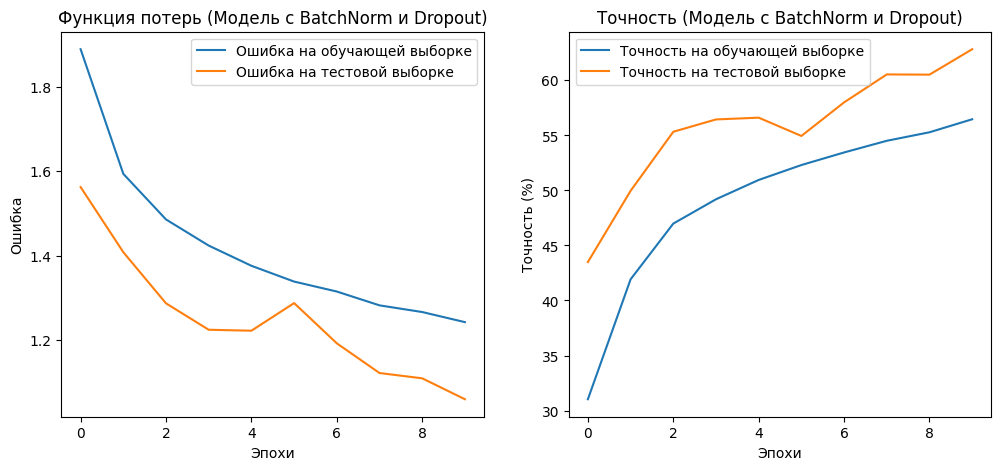

Обучение модели: Модель с увеличенными фильтрами
Epoch 1/30, Train Loss: 2.0575, Train Acc: 27.77%, Test Loss: 1.6720, Test Acc: 39.69%
Epoch 2/30, Train Loss: 1.6484, Train Acc: 39.43%, Test Loss: 1.3998, Test Acc: 49.50%
Epoch 3/30, Train Loss: 1.5239, Train Acc: 44.86%, Test Loss: 1.3468, Test Acc: 52.83%
Epoch 4/30, Train Loss: 1.4481, Train Acc: 47.61%, Test Loss: 1.3642, Test Acc: 51.49%
Epoch 5/30, Train Loss: 1.3955, Train Acc: 50.03%, Test Loss: 1.2708, Test Acc: 55.72%
Epoch 6/30, Train Loss: 1.3595, Train Acc: 51.55%, Test Loss: 1.1615, Test Acc: 59.74%
Epoch 7/30, Train Loss: 1.3205, Train Acc: 52.97%, Test Loss: 1.1264, Test Acc: 60.36%
Epoch 8/30, Train Loss: 1.2922, Train Acc: 54.25%, Test Loss: 1.1588, Test Acc: 59.02%
Epoch 9/30, Train Loss: 1.2737, Train Acc: 54.78%, Test Loss: 1.0845, Test Acc: 61.84%
Epoch 10/30, Train Loss: 1.2418, Train Acc: 55.80%, Test Loss: 1.1192, Test Acc: 60.76%
Epoch 11/30, Train Loss: 1.2253, Train Acc: 56.52%, Test Loss: 1.0492, Test Acc:

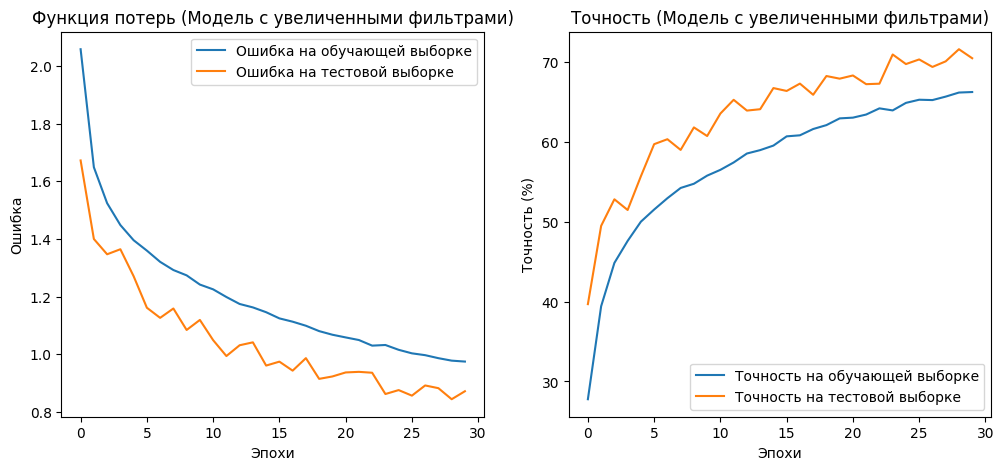

In [28]:
# Модель с BatchNorm и Dropout
class NetAdvanced(nn.Module):
    def __init__(self):
        super(NetAdvanced, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 1 канал на входе
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm после первого сверточного слоя
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm после второго сверточного слоя
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 8x8 для изображений 32x32 после двух пулингов
        self.dropout = nn.Dropout(0.5)  # Dropout для полносвязного слоя
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = x.view(-1, 64 * 8 * 8)  # преобразование в вектор
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Модель с увеличенным количеством фильтров
class NetDeep(nn.Module):
    def __init__(self):
        super(NetDeep, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  # 1 канал на входе, больше фильтров
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm после первого сверточного слоя
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # больше фильтров
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm после второго сверточного слоя
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)  # больше нейронов
        self.dropout = nn.Dropout(0.5)  # Dropout для полносвязного слоя
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))  # 32x32 -> 16x16
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))  # 16x16 -> 8x8
        x = x.view(-1, 128 * 8 * 8)  # преобразование в вектор
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
def train_and_evaluate(model, trainloader, testloader, model_name, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print(f"Обучение модели: {model_name}")
    train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(
        model, optimizer, criterion, trainloader, testloader, epochs
    )
    
    # визуализация результатов
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Ошибка на обучающей выборке')
    plt.plot(test_loss_history, label='Ошибка на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.title(f'Функция потерь ({model_name})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Точность на обучающей выборке')
    plt.plot(test_acc_history, label='Точность на тестовой выборке')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность (%)')
    plt.title(f'Точность ({model_name})')
    plt.legend()
    
    plt.show()

# обучение и оценка модели с увеличенным количеством фильтров
model_deep = NetDeep()
train_and_evaluate(model_deep, trainloader_cifar, testloader_cifar, "Модель с увеличенными фильтрами", epochs=30)

Обучение модели: Модель с BatchNorm и Dropout
Epoch 1/30, Train Loss: 1.8534, Train Acc: 32.45%, Test Loss: 1.5719, Test Acc: 43.66%
Epoch 2/30, Train Loss: 1.5795, Train Acc: 42.61%, Test Loss: 1.3834, Test Acc: 50.15%
Epoch 3/30, Train Loss: 1.4704, Train Acc: 46.87%, Test Loss: 1.2842, Test Acc: 55.40%
Epoch 4/30, Train Loss: 1.4128, Train Acc: 49.44%, Test Loss: 1.3428, Test Acc: 52.32%
Epoch 5/30, Train Loss: 1.3550, Train Acc: 51.64%, Test Loss: 1.1663, Test Acc: 58.79%
Epoch 6/30, Train Loss: 1.3189, Train Acc: 53.47%, Test Loss: 1.1529, Test Acc: 60.01%
Epoch 7/30, Train Loss: 1.2856, Train Acc: 54.66%, Test Loss: 1.1606, Test Acc: 59.30%
Epoch 8/30, Train Loss: 1.2515, Train Acc: 55.76%, Test Loss: 1.1300, Test Acc: 60.02%
Epoch 9/30, Train Loss: 1.2268, Train Acc: 56.71%, Test Loss: 1.1186, Test Acc: 60.45%
Epoch 10/30, Train Loss: 1.2087, Train Acc: 57.42%, Test Loss: 1.0585, Test Acc: 63.18%
Epoch 11/30, Train Loss: 1.1927, Train Acc: 58.12%, Test Loss: 1.0465, Test Acc: 63

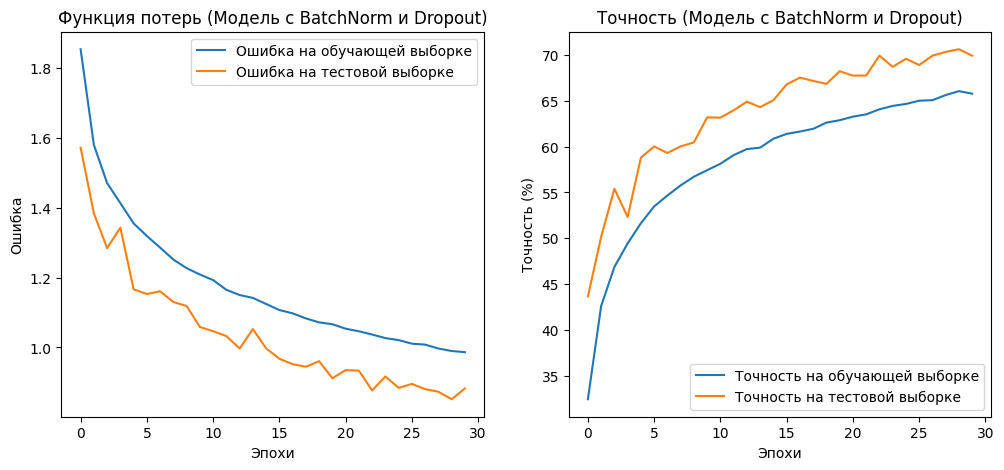

In [29]:
# обучение и оценка модели с BatchNorm и Dropout
model_advanced = NetAdvanced()
train_and_evaluate(model_advanced, trainloader_cifar, testloader_cifar, "Модель с BatchNorm и Dropout", epochs=30)

Добавление DroupOut позволяет снизить ошибки на тестовой выборке:

* Помогает уменьшить разрыв между ошибкой на обучающей и тестовой выборках.
* Cлучайно отключает нейроны, поэтому обучение может занять больше времени.
* Модель становится менее чувствительной к шуму в данных.

Увеличение количества фильтров приводит к:

* Модель может извлекать больше разнообразных признаков из данных. Это особенно полезно для сложных задач, где важно учитывать множество деталей (например, классификация изображений с большим количеством классов).
* Улучшение качества модели из-за лучшего извлечения признаков и более точному пониманию данных, что часто приводит к повышению точности на тестовой выборке.
* Больше фильтров позволяет модели лучше комбинировать признаки и находить более сложные закономерности.
* Увеличение глубины представлений, т.к. каждый фильтр работает как отдельный детектор признаков и как следствие это ведет к большему числу независимых детекторов и способности модели к обобщению.

По факту результат не был улучшен. Это могло произойти из-за неправильных выбранных параметров

Epoch 1/30, Train Loss: 2.2736, Train Acc: 16.19%, Test Loss: 2.2176, Test Acc: 21.94%
Epoch 2/30, Train Loss: 2.1698, Train Acc: 21.77%, Test Loss: 2.1216, Test Acc: 24.32%
Epoch 3/30, Train Loss: 2.1042, Train Acc: 24.37%, Test Loss: 2.0493, Test Acc: 27.64%
Epoch 4/30, Train Loss: 2.0350, Train Acc: 27.40%, Test Loss: 1.9696, Test Acc: 30.46%
Epoch 5/30, Train Loss: 1.9688, Train Acc: 29.51%, Test Loss: 1.9142, Test Acc: 31.88%
Epoch 6/30, Train Loss: 1.9088, Train Acc: 31.58%, Test Loss: 1.8494, Test Acc: 34.36%
Epoch 7/30, Train Loss: 1.8555, Train Acc: 33.46%, Test Loss: 1.7944, Test Acc: 36.04%
Epoch 8/30, Train Loss: 1.8102, Train Acc: 34.84%, Test Loss: 1.7463, Test Acc: 36.89%
Epoch 9/30, Train Loss: 1.7738, Train Acc: 35.93%, Test Loss: 1.7152, Test Acc: 38.80%
Epoch 10/30, Train Loss: 1.7402, Train Acc: 37.20%, Test Loss: 1.6949, Test Acc: 38.79%
Epoch 11/30, Train Loss: 1.7167, Train Acc: 37.99%, Test Loss: 1.6742, Test Acc: 39.77%
Epoch 12/30, Train Loss: 1.6952, Train Ac

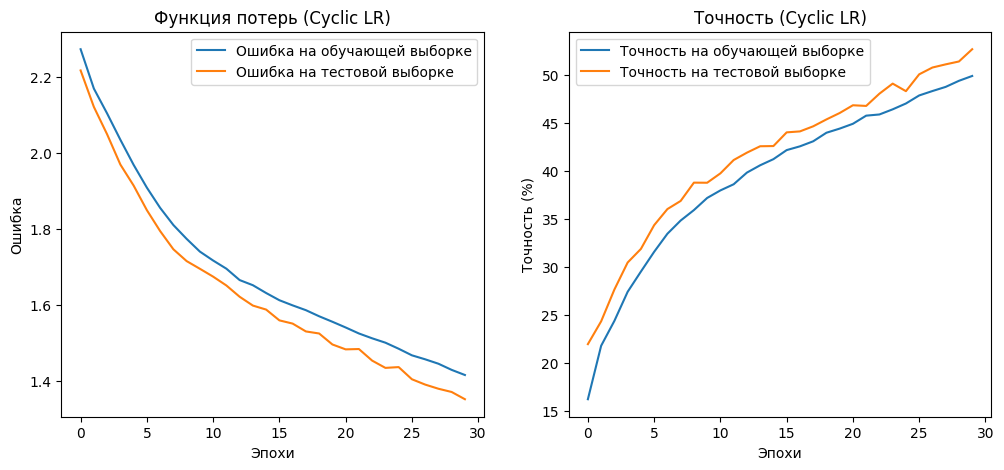

In [30]:
# реализация циклического learning rate
from torch.optim.lr_scheduler import CyclicLR

# инициализация модели, функции потерь и оптимизатора
model_cyclic = Net()
criterion = nn.CrossEntropyLoss()
optimizer_cyclic = optim.SGD(model_cyclic.parameters(), lr=0.001, momentum=0.9)

# настройка CyclicLR
scheduler_cyclic = CyclicLR(optimizer_cyclic, base_lr=0.001, max_lr=0.01, step_size_up=2000, mode='triangular')

# обучение с циклическим learning rate
train_loss_history_cyclic, train_acc_history_cyclic, test_loss_history_cyclic, test_acc_history_cyclic = train_model(
    model_cyclic, optimizer_cyclic, criterion, trainloader_cifar, testloader_cifar, epochs=30
)

# визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history_cyclic, label='Ошибка на обучающей выборке')
plt.plot(test_loss_history_cyclic, label='Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Функция потерь (Cyclic LR)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history_cyclic, label='Точность на обучающей выборке')
plt.plot(test_acc_history_cyclic, label='Точность на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.title('Точность (Cyclic LR)')
plt.legend()

plt.show()

Epoch 1/50, Train Loss: 1.4020, Train Acc: 50.27%, Test Loss: 1.3425, Test Acc: 52.47%
Epoch 2/50, Train Loss: 1.3935, Train Acc: 50.70%, Test Loss: 1.3251, Test Acc: 53.64%
Epoch 3/50, Train Loss: 1.3785, Train Acc: 51.49%, Test Loss: 1.3133, Test Acc: 54.05%
Epoch 4/50, Train Loss: 1.3608, Train Acc: 52.02%, Test Loss: 1.3030, Test Acc: 54.64%
Epoch 5/50, Train Loss: 1.3503, Train Acc: 52.58%, Test Loss: 1.2863, Test Acc: 54.87%
Epoch 6/50, Train Loss: 1.3413, Train Acc: 52.86%, Test Loss: 1.2823, Test Acc: 54.90%
Epoch 7/50, Train Loss: 1.3247, Train Acc: 53.35%, Test Loss: 1.2670, Test Acc: 55.21%
Epoch 8/50, Train Loss: 1.3172, Train Acc: 53.65%, Test Loss: 1.2490, Test Acc: 56.52%
Epoch 9/50, Train Loss: 1.3078, Train Acc: 53.98%, Test Loss: 1.2432, Test Acc: 56.05%
Epoch 10/50, Train Loss: 1.2931, Train Acc: 54.60%, Test Loss: 1.2286, Test Acc: 57.04%
Epoch 11/50, Train Loss: 1.2815, Train Acc: 54.99%, Test Loss: 1.2508, Test Acc: 56.79%
Epoch 12/50, Train Loss: 1.2733, Train Ac

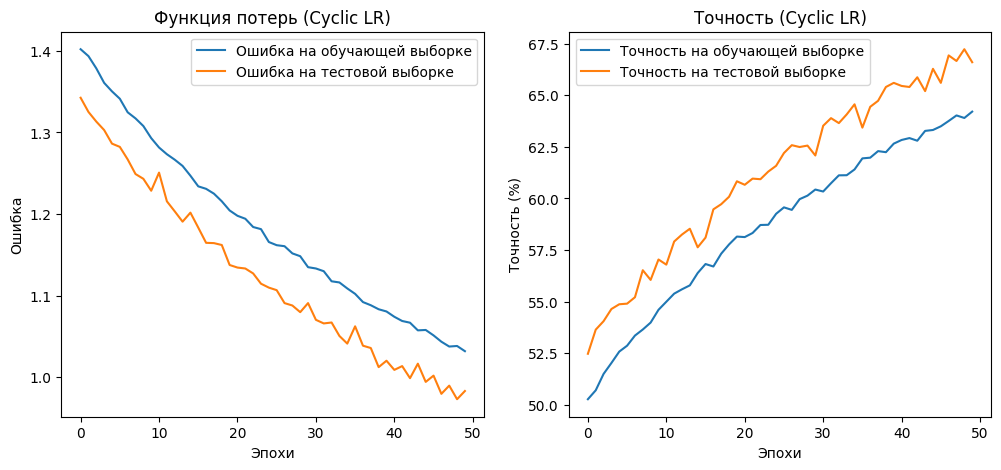

In [32]:
# обучение с циклическим learning rate
train_loss_history_cyclic, train_acc_history_cyclic, test_loss_history_cyclic, test_acc_history_cyclic = train_model(
    model_cyclic, optimizer_cyclic, criterion, trainloader_cifar, testloader_cifar, epochs=50
)

# визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history_cyclic, label='Ошибка на обучающей выборке')
plt.plot(test_loss_history_cyclic, label='Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Функция потерь (Cyclic LR)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history_cyclic, label='Точность на обучающей выборке')
plt.plot(test_acc_history_cyclic, label='Точность на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.title('Точность (Cyclic LR)')
plt.legend()

plt.show()

Использование циклического learning rate позволяет:

* Модели быстрее находить хорошие области пространства параметров, так как большие значения learning rate помогают "перепрыгивать" локальные минимумы.
* В процессе обучения помогает модели избежать застревания в плохих локальных минимумах и улучшает её способность к обобщению.
* Избавляет от необходимости вручную подбирать оптимальное значение learning rate
* Делает модель менее чувствительной к начальным значениям параметров, так как большие значения learning rate помогают быстро выйти из плохих областей.
* Добавляет стохастичности в процесс обучения, что может помочь избежать переобучения.

Однако, это требует большего числа эпох. Результат модели на 50 эпопах оказался немного хуже оригинальной модели.

/root/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 2.0648, Train Acc: 25.17%, Test Loss: 1.7947, Test Acc: 34.50%
Epoch 2/30, Train Loss: 1.7379, Train Acc: 36.68%, Test Loss: 1.5927, Test Acc: 42.51%
Epoch 3/30, Train Loss: 1.6047, Train Acc: 42.14%, Test Loss: 1.5019, Test Acc: 45.86%
Epoch 4/30, Train Loss: 1.4884, Train Acc: 47.04%, Test Loss: 1.3454, Test Acc: 52.74%
Epoch 5/30, Train Loss: 1.3835, Train Acc: 50.92%, Test Loss: 1.3051, Test Acc: 54.30%
Epoch 6/30, Train Loss: 1.3070, Train Acc: 53.93%, Test Loss: 1.1874, Test Acc: 58.27%
Epoch 7/30, Train Loss: 1.2351, Train Acc: 56.54%, Test Loss: 1.1504, Test Acc: 59.64%
Epoch 8/30, Train Loss: 1.1817, Train Acc: 58.60%, Test Loss: 1.0883, Test Acc: 62.28%
Epoch 9/30, Train Loss: 1.1426, Train Acc: 59.91%, Test Loss: 1.0509, Test Acc: 63.77%
Epoch 10/30, Train Loss: 1.0937, Train Acc: 61.75%, Test Loss: 0.9929, Test Acc: 66.10%
Epoch 11/30, Train Loss: 1.0562, Train Acc: 63.19%, Test Loss: 0.9702, Test Acc: 66.79%
Epoch 12/30, Train Loss: 1.0291, Train Ac

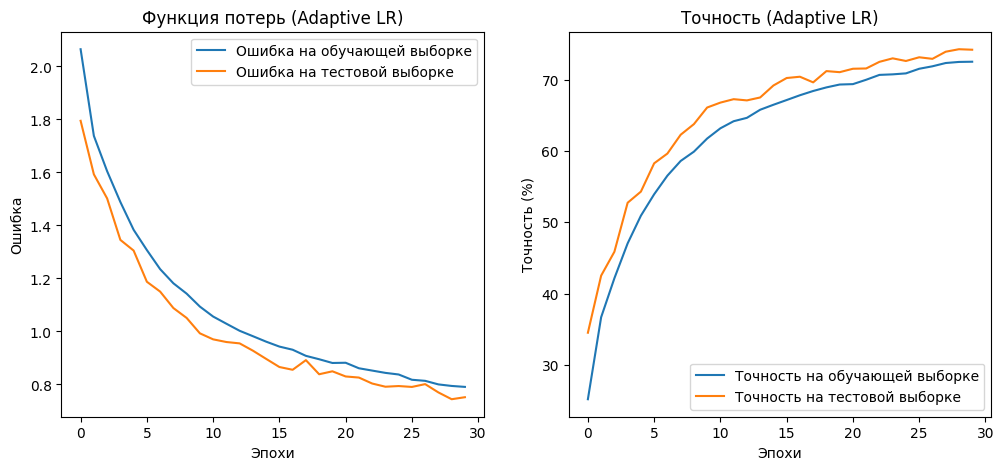

In [33]:
# реализация адаптивного learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau

# инициализация модели, функции потерь и оптимизатора
model_adaptive = Net()
criterion = nn.CrossEntropyLoss()
optimizer_adaptive = optim.SGD(model_adaptive.parameters(), lr=0.01, momentum=0.9)

# настройка ReduceLROnPlateau
scheduler_adaptive = ReduceLROnPlateau(optimizer_adaptive, mode='min', factor=0.1, patience=2, verbose=True)

# обучение с адаптивным learning rate
train_loss_history_adaptive, train_acc_history_adaptive, test_loss_history_adaptive, test_acc_history_adaptive = train_model(
    model_adaptive, optimizer_adaptive, criterion, trainloader_cifar, testloader_cifar, epochs=30
)

# визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history_adaptive, label='Ошибка на обучающей выборке')
plt.plot(test_loss_history_adaptive, label='Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Функция потерь (Adaptive LR)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history_adaptive, label='Точность на обучающей выборке')
plt.plot(test_acc_history_adaptive, label='Точность на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.title('Точность (Adaptive LR)')
plt.legend()

plt.show()

Плюсы адаптивного близки к цикличному подбору. На данных этот метод показал себя лучше остальных и дал наибольшую точность 

Epoch 1/10, Train Loss: 2.2975, Train Acc: 11.42%, Test Loss: 2.2892, Test Acc: 14.98%
Epoch 2/10, Train Loss: 2.2808, Train Acc: 16.07%, Test Loss: 2.2685, Test Acc: 19.09%
Epoch 3/10, Train Loss: 2.2559, Train Acc: 18.32%, Test Loss: 2.2337, Test Acc: 21.41%
Epoch 4/10, Train Loss: 2.2183, Train Acc: 20.04%, Test Loss: 2.1921, Test Acc: 21.77%
Epoch 5/10, Train Loss: 2.1833, Train Acc: 20.67%, Test Loss: 2.1574, Test Acc: 22.69%
Epoch 6/10, Train Loss: 2.1592, Train Acc: 21.61%, Test Loss: 2.1373, Test Acc: 23.31%
Epoch 7/10, Train Loss: 2.1412, Train Acc: 22.72%, Test Loss: 2.1178, Test Acc: 24.53%
Epoch 8/10, Train Loss: 2.1227, Train Acc: 23.75%, Test Loss: 2.0965, Test Acc: 25.67%
Epoch 9/10, Train Loss: 2.1064, Train Acc: 24.30%, Test Loss: 2.0815, Test Acc: 26.28%
Epoch 10/10, Train Loss: 2.0906, Train Acc: 24.88%, Test Loss: 2.0684, Test Acc: 26.61%
Epoch 11/10, Train Loss: 2.0713, Train Acc: 26.04%, Test Loss: 2.0468, Test Acc: 28.40%
Epoch 12/10, Train Loss: 2.0589, Train Ac

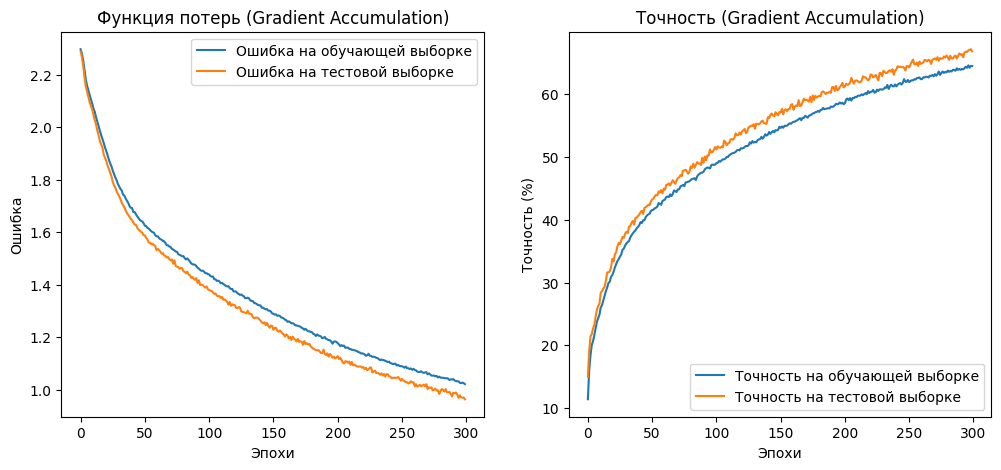

In [35]:
# реализация накопления градиентов
accumulation_steps = 4  # количество шагов для накопления градиентов

# инициализация модели, функции потерь и оптимизатора
model_accumulation = Net()
criterion = nn.CrossEntropyLoss()
optimizer_accumulation = optim.SGD(model_accumulation.parameters(), lr=0.001, momentum=0.9)

# обучение с накоплением градиентов
train_loss_history_accumulation = []
train_acc_history_accumulation = []
test_loss_history_accumulation = []
test_acc_history_accumulation = []

for epoch in range(300):
    model_accumulation.train()
    running_loss = 0.0
    correct = 0
    total = 0
    optimizer_accumulation.zero_grad()

    for i, (inputs, labels) in enumerate(trainloader_cifar):
        outputs = model_accumulation(inputs)
        loss = criterion(outputs, labels) / accumulation_steps  # нормализация по шагам
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # обновление весов каждые accumulation_steps шагов
            optimizer_accumulation.step()
            optimizer_accumulation.zero_grad()

        running_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # сохранение ошибки и точности для обучающей выборки
    train_loss = running_loss / len(trainloader_cifar)
    train_acc = 100 * correct / total
    train_loss_history_accumulation.append(train_loss)
    train_acc_history_accumulation.append(train_acc)

    # оценка на тестовой выборке
    model_accumulation.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader_cifar:
            outputs = model_accumulation(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # сохранение ошибки и точности для тестовой выборки
    test_loss = test_loss / len(testloader_cifar)
    test_acc = 100 * correct / total
    test_loss_history_accumulation.append(test_loss)
    test_acc_history_accumulation.append(test_acc)

    # вывод статистики
    print(f'Epoch {epoch + 1}/300, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# визуализация результатов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history_accumulation, label='Ошибка на обучающей выборке')
plt.plot(test_loss_history_accumulation, label='Ошибка на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка')
plt.title('Функция потерь (Gradient Accumulation)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history_accumulation, label='Точность на обучающей выборке')
plt.plot(test_acc_history_accumulation, label='Точность на тестовой выборке')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.title('Точность (Gradient Accumulation)')
plt.legend()

plt.show()